# Capstone project 1: Pet Product Auto-Subcategorization by Review Analysis (preprocessing)

**Goal: Creating a system that automatically classifies products in Pet Supplies category into subcategories by analyzing the reviews.**  
In this project, the data collected during 2014 - 2015 in the US is used.

## 1. Loading Data

In [1]:
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import csv

sns.set(context='notebook', style='ticks', palette='hls')

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle the code on/off."></form>''')

The dataset is available on https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Pet_Products_v1_00.tsv.gz

In [3]:
# Load the tsv file with columns which will be used
data = pd.read_table('amazon_reviews_us_Pet_Products_v1_00.tsv', usecols=[0,4,5,6,13,14])
data.head()

,marketplace,product_parent,product_title,product_category,review_body,review_date
0,US,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Pet Products,Best belly bands on the market! These are a g...,2015-08-31
1,US,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,Pet Products,"My dogs love Hugs and Kisses. However, the la...",2015-08-31
2,US,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,Pet Products,I have been purchasing these for a long time. ...,2015-08-31
3,US,568880110,"Soft Side Pet Crate, Navy/Tan",Pet Products,"It is extremely well constructed, it is easy t...",2015-08-31
4,US,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Pet Products,Worked really well. Very pleased with my purc...,2015-08-31


In [4]:
# Change the clomun label from 'product_parent' to 'product_id'
data = data.rename(columns={'product_parent':'product_id'})
data.head()

,marketplace,product_id,product_title,product_category,review_body,review_date
0,US,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Pet Products,Best belly bands on the market! These are a g...,2015-08-31
1,US,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,Pet Products,"My dogs love Hugs and Kisses. However, the la...",2015-08-31
2,US,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,Pet Products,I have been purchasing these for a long time. ...,2015-08-31
3,US,568880110,"Soft Side Pet Crate, Navy/Tan",Pet Products,"It is extremely well constructed, it is easy t...",2015-08-31
4,US,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Pet Products,Worked really well. Very pleased with my purc...,2015-08-31


In [5]:
# Check the general information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2639981 entries, 0 to 2639980
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   marketplace       object
 1   product_id        int64 
 2   product_title     object
 3   product_category  object
 4   review_body       object
 5   review_date       object
dtypes: int64(1), object(5)
memory usage: 120.8+ MB


In [6]:
# Is there any missing date?: Yes
data.isnull().any(axis=0)

marketplace         False
product_id          False
product_title        True
product_category    False
review_body          True
review_date          True
dtype: bool

## 2. Data Wrangling

#### Approach:

2.1. Extracting data collected in 2014 or 2015  
2.2. Removing columns having a single value  
2.3. Dealing with missing values and duplicate data  
2.4. Removing short and long reviews    
2.5. Adjusting the number of reviews per product  
2.6. Merging reviews to the same product in one  
2.7. Tokenization  
2.8. Retaining only alphabets  
2.9. Removing stop words  
2.10. Stemming and lemmatization  
2.11. Retaining only nouns  
2.12. Removing words appearing 4 times or less 

### 2.1. Extracting data collected in 2014 or 2015

In [7]:
# Extract data in 2015 (ignore data without a date label)
df_2015 = data[data['review_date'].str.contains('2015-', na=False)] 
df_2015.head()

,marketplace,product_id,product_title,product_category,review_body,review_date
0,US,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Pet Products,Best belly bands on the market! These are a g...,2015-08-31
1,US,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,Pet Products,"My dogs love Hugs and Kisses. However, the la...",2015-08-31
2,US,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,Pet Products,I have been purchasing these for a long time. ...,2015-08-31
3,US,568880110,"Soft Side Pet Crate, Navy/Tan",Pet Products,"It is extremely well constructed, it is easy t...",2015-08-31
4,US,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Pet Products,Worked really well. Very pleased with my purc...,2015-08-31


In [8]:
# Check the number of the rows
len(df_2015)

875524

In [9]:
# Extract data in 2014 (ignore data without a date label)
df_2014 = data[data['review_date'].str.contains('2014-', na=False)] 
df_2014.head()

,marketplace,product_id,product_title,product_category,review_body,review_date
875589,US,384773221,Flea Control Killer 12 Monthly Capsules of Luf...,Pet Products,Been working good so far.,2014-12-31
875590,US,226765263,Four Paws Wee-Wee Pet Training and Puppy Pads,Pet Products,"Great pads, they work great! Also great value,...",2014-12-31
875591,US,698924655,Cockatiel Nutri-Berries,Pet Products,Got here faster loved it & my Quaker parrots L...,2014-12-31
875592,US,456586629,Willow Branch Ball for Small Animals,Pet Products,"Bunny likes it, but I'd like it to last longer.",2014-12-31
875593,US,438365490,Rubies Costume Rubies Princess Pet Costume,Pet Products,Too small for my german shepherd,2014-12-31


In [10]:
# Check the number of the rows
len(df_2014)

829705

In [11]:
# Merge the two dataframes
df_two_years = df_2015.append(df_2014)
df_two_years.head()

,marketplace,product_id,product_title,product_category,review_body,review_date
0,US,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Pet Products,Best belly bands on the market! These are a g...,2015-08-31
1,US,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,Pet Products,"My dogs love Hugs and Kisses. However, the la...",2015-08-31
2,US,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,Pet Products,I have been purchasing these for a long time. ...,2015-08-31
3,US,568880110,"Soft Side Pet Crate, Navy/Tan",Pet Products,"It is extremely well constructed, it is easy t...",2015-08-31
4,US,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Pet Products,Worked really well. Very pleased with my purc...,2015-08-31


In [12]:
# Count the number of the rows
len(df_two_years)

1705229

### 2.2. Removing columns having a single value

In [13]:
# Check if all 'marketplace' vlaues are 'US'
print(len(df_two_years[df_two_years['marketplace'] != 'US']))

# Check if all 'product_category' values are 'Pet Products'
print(len(df_two_years[df_two_years['product_category'] != 'Pet Products']))

0
0


There is no incorrect value. 

In [14]:
# Remove the two columns and 'review_date' column
df = df_two_years[['product_id', 'product_title', 'review_body']]
df.head()

,product_id,product_title,review_body
0,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Best belly bands on the market! These are a g...
1,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,"My dogs love Hugs and Kisses. However, the la..."
2,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,I have been purchasing these for a long time. ...
3,568880110,"Soft Side Pet Crate, Navy/Tan","It is extremely well constructed, it is easy t..."
4,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Worked really well. Very pleased with my purc...


### 2.3. Dealing with missing values and duplicate data

#### 2.3.1. Removing missing values

In [15]:
# How many products in df?
df['product_id'].nunique()

128995

In [16]:
# Is there any missing date?
df.isnull().sum()

product_id         0
product_title      0
review_body      216
dtype: int64

In [17]:
# If droping the rows having null, how many products will be removed?
df_dropna = df.dropna(how='any')
df['product_id'].nunique() - df_dropna['product_id'].nunique()

18

I have decided to remove these products from this model because a product without a review is not an active pruduct.  
The products are shown as a list for later.

In [18]:
# Extrct the products' names
products_df = df[['product_id', 'product_title']].drop_duplicates()
products_dropna = df_dropna[['product_id', 'product_title']].drop_duplicates()
null_reviews = products_df[~products_df['product_id'].isin(products_dropna['product_id'])]

# Set the index to 'product_id' column
null_reviews = null_reviews.set_index(['product_id']).sort_index()

# Show the list
print(null_reviews)

                                                product_title
product_id                                                   
59503872    {Factory Direct Sale} 100Pcs Set Poultry Leg B...
111888120   Genuine Leather Dog Harness, Medium. 25.5"-29"...
173421502   Dean & Tyler 26 to 37-Inch Strong Nylon Cobra ...
194817456   Generic New Pet Dog Cat Leather Spike Stud Col...
299399624   Mirage Pet Bitches Love Me Screen Print Dog Ba...
404027221   Mosunx(TM) Hot Pet Dog Puppy Tutu Princess Dre...
418434105   Saddle Bag Pet Dogs Backpack Travel Hiking Har...
490871023   Casual Canine Reindeer Hoodie for Dogs, 10" XS...
507641146   San Francisco Bay Brand Herp Instant Meal Turt...
556866786   The Dog Squad Minkie Binkie Pet Blanket, Mediu...
721172262              AquaTop Aquarium Air Blower, 180 Watts
761779284           Coral Pink Rosettes PETS Tutu Party Dress
767317796   MLB BANDANA - CLEVELAND INDIANS DOG BANDANA wi...
803837812                YAP Technology Dog Harness - Red (L)
82834048

Table1. No review products list

#### 2.3.2. Removing duplicate data

In [19]:
# Remove duplicate data: 8004 duplicate data
df_drop_dup = df_dropna.drop_duplicates()
len(df) - len(df_drop_dup)

8004

In [20]:
# Show the number of reviews in df_drop_dup
len(df_drop_dup)

1697225

In [21]:
# Show the number of products in df_drop_dup
df_drop_dup['product_id'].nunique()

128977

### 2.4. Removing short and long reviews

In [22]:
# Count the number of characters in a review
review_length = df_drop_dup['review_body'].str.len()

In [23]:
# Show the summary statistics
review_length.describe()

count    1.697225e+06
mean     2.336816e+02
std      3.471153e+02
min      1.000000e+00
25%      5.900000e+01
50%      1.360000e+02
75%      2.810000e+02
max      4.439900e+04
Name: review_body, dtype: float64

In [24]:
# 95 percentile
review_length.quantile(0.95)

760.0

<IPython.core.display.Javascript object>


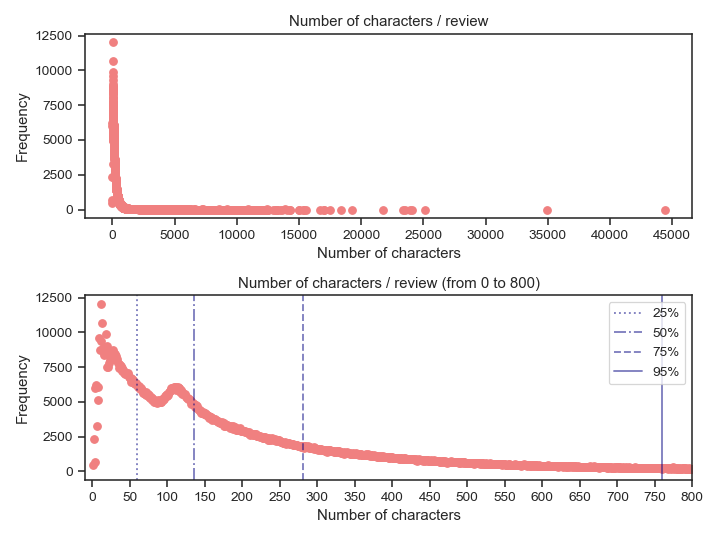

In [25]:
# Create a count plot
length_counter = Counter(review_length)

plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.scatter(length_counter.keys(), length_counter.values(), c='lightcoral')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 45000 + 1, 5000))
plt.title('Number of characters / review')

plt.subplot(2,1,2)
plt.scatter(length_counter.keys(), length_counter.values(), c='lightcoral')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.xlim([-10,800])
plt.xticks(np.arange(0, 800 + 1, 50))
plt.axvline(x=59, ymin=0, ymax=12500, c='navy', alpha=0.5, label='25%', ls=':')
plt.axvline(x=136, ymin=0, ymax=12500, c='navy', alpha=0.5, label='50%', ls='-.')
plt.axvline(x=281, ymin=0, ymax=12500, c='navy', alpha=0.5, label='75%', ls='--')
plt.axvline(x=760, ymin=0, ymax=12500, c='navy', alpha=0.5, label='95%', ls='-')
plt.title('Number of characters / review (from 0 to 800)')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

95th percentile was 760 characters per review. I think 760 characters are enough to describe the products. Longer reviews will make the model complicated. Let's remove the longer reviews more than 760.

In [26]:
# Remove reviews longer than 760
df_less760_chara = df_drop_dup.query('review_body.str.len() <= 760')
len(df_less760_chara)

1612532

84,693 (1,697,225 - 1,612,532) reviews were removed.

In [27]:
# Check the reviews having only one character
df_less760_chara.query('review_body.str.len() == 1').head()

,product_id,product_title,review_body
1116,167929142,Littermaid Receptacles,f
2080,230993905,RFA-188 3-Volt Lithium Battery,k
2090,698234953,Instinct Grain Free All Natural Oven-Baked Bis...,1
3905,264157737,Nutramax Denamarin Supplemental Tablets,K
4407,350664549,PetSafe 6-Volt Lithium Battery (2 Batteries pe...,😀


In [28]:
# Check the reviews having two character
df_less760_chara.query('review_body.str.len() == 2').head()

,product_id,product_title,review_body
275,694724594,Tetra 77035 TetraFin Floating Variety Pellets,OK
2178,58740630,Giant Mealworms - Jumbo Mealworms for Feeding ...,:/
3837,78582590,Wahl Pet Clipper Hair Cutting Kit for touch up...,ok
4519,852092603,Yescom Aquarium Internal Filter 3in1 80GPH 300...,Ok
5002,666431592,Petvi all natural probiotic nutritional supple...,ok


In [29]:
# The number of the products removed
df_drop_dup['product_id'].nunique() - df_less760_chara['product_id'].nunique()

2210

2,210 products are 1.7% of the total.

Short reviews might not have enough information to characterize the product. I am removing reviews having fewer than 30 characters.

In [30]:
# Remove reviews having fewer than 30 characters
df_more30_chara = df_less760_chara.query('review_body.str.len() >= 30')
len(df_more30_chara)

1396300

216,232 (1,612,532 - 1,396,300) reviews were removed.

In [31]:
# The number of the products removed
df_less760_chara['product_id'].nunique() - df_more30_chara['product_id'].nunique()

9967

9,967 products is 7.7% of the total.
I am going to show the products removed as a table.

I am going to show the products removed as a table.

In [32]:
# Extrct the products' names
products_more30_chara = df_more30_chara[['product_id', 'product_title']].drop_duplicates()
short_reviews = products_dropna[~products_dropna['product_id'].isin(products_more30_chara['product_id'])]

# Set the index to 'product_id' column
short_reviews = short_reviews.set_index(['product_id']).sort_index()

# Show the list
print(short_reviews)

                                                product_title
product_id                                                   
13903       Mr Bites 9-Inch Rawhide Retriever Roll for Dog...
114505      1000 Live Superworms-Reptile, Birds, Fishing B...
125740             JurassiDiet - Newt & Frog, 120 g / 4.2 oz.
210582      Marineland C-Series C-160 & C-220 Canister Fil...
320416      Pet Champion 1.25-Inch Cushion Herringbone Dog...
...                                                       ...
999682628   Tampa Bay Lightning Pet Dog Pink Performance T...
999703990   San Francisco Bay Brand ASF71120 Freeze Dried ...
999759324   Hartz Delectables Gourmet Treats for Cats Roas...
999845182   North American Salt 90001 Round Salt Spool Pet...
999868557   Replacement Filter Cartridges Size: Large (4" ...

[12190 rows x 1 columns]


Table2. Short review products list

The number of the removed products should be 12,177, but 12,190.

In [33]:
# Check the number of products in short_reviews
short_reviews.index.nunique()

12177

The differenct was caused by some products having two different product titles.

In [34]:
# Show the number of reviews in df_more30_chara
len(df_more30_chara)

1396300

In [35]:
# Show the number of products in df_more30_chara
df_more30_chara['product_id'].nunique()

116800

Now, there are 1,396,300 observations (reviews) and 116,800 products. 

### 2.5. Adjusting the number of reviews per product

The number of reviews per product is adjusted to be ten to make this model efficient. As the result, many products having less reviews are removed. These removed products would not be very active because they have a few reviews.

In [36]:
# Recheck df_more30_chara
df_more30_chara.head()

,product_id,product_title,review_body
0,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Best belly bands on the market! These are a g...
1,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,"My dogs love Hugs and Kisses. However, the la..."
2,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,I have been purchasing these for a long time. ...
3,568880110,"Soft Side Pet Crate, Navy/Tan","It is extremely well constructed, it is easy t..."
4,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Worked really well. Very pleased with my purc...


In [37]:
# Group by 'product_id' and count the number of reviews for each product
df_count_by_product = df_more30_chara[['product_id', 'review_body']].groupby('product_id').count()

# Change the column label
df_count_by_product.columns = ['number_of_reviews']

In [38]:
df_count_by_product.describe()

,number_of_reviews
count,116800.000000
mean,11.954623
std,62.215982
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,4285.000000


In [39]:
# 95 percentile
df_count_by_product.quantile(0.95)

number_of_reviews    42.0
Name: 0.95, dtype: float64

<IPython.core.display.Javascript object>


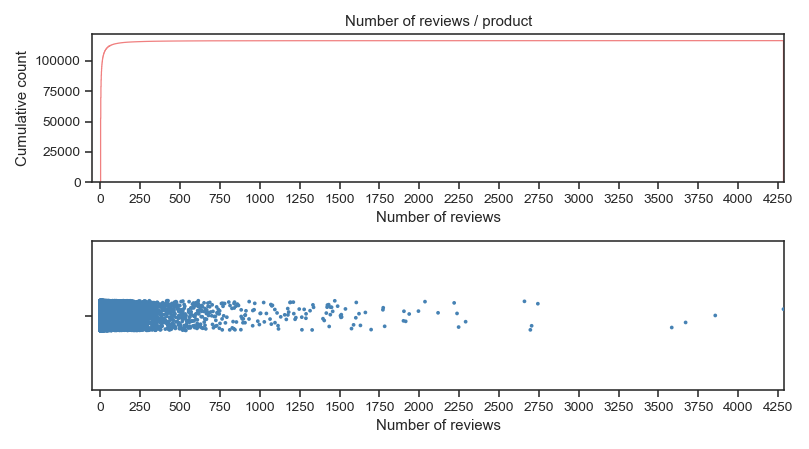

In [40]:
# Draw a strip plot and a count plot
plt.figure(figsize=(9,5))

plt.subplot(2,1,1)
plt.hist(df_count_by_product['number_of_reviews'], bins=4285, cumulative=True, histtype='step', color='lightcoral')
plt.xlim([-50,4290])
plt.xticks(range(0,4300,250))
plt.xlabel('Number of reviews')
plt.ylabel('Cumulative count')
plt.title('Number of reviews / product')

plt.subplot(2,1,2)
sns.stripplot(x='number_of_reviews', data=df_count_by_product, size=3, color='steelblue', jitter=True)
plt.xlim([-50,4290])
plt.xticks(range(0,4300,250))
plt.xlabel('Number of reviews')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


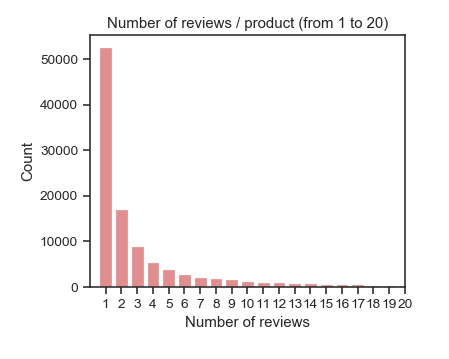

In [41]:
# Draw a strip plot and a count plot
plt.figure(figsize=(5,4))

sns.countplot(x='number_of_reviews', data=df_count_by_product, color='lightcoral')
plt.xlim([-1,19])
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.title('Number of reviews / product (from 1 to 20)')

plt.subplots_adjust(left=0.2, right=0.90, bottom=0.2, top=0.90)
plt.show()

There are many products having a few reviews.

In [42]:
# Count the number of products having 10 or more reviews
df_count_more10 = df_count_by_product[df_count_by_product['number_of_reviews'] >= 10]
len(df_count_more10)

19557

In [43]:
# Extract rows which products have 10 or more reviews
df_more10 = df_more30_chara[df_more30_chara['product_id'].isin(df_count_more10.index)]
df_more10

,product_id,product_title,review_body
0,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Best belly bands on the market! These are a g...
1,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,"My dogs love Hugs and Kisses. However, the la..."
3,568880110,"Soft Side Pet Crate, Navy/Tan","It is extremely well constructed, it is easy t..."
4,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Worked really well. Very pleased with my purc...
5,590674141,Carlson 68-Inch Wide Adjustable Freestanding P...,I love my gates! They look beautiful and they...
...,...,...,...
1705353,271676173,Hartz UltraGuard Ear Mite Treatment for Cats,Solved my poor kitten’s ear mite issue. And ve...
1705354,543482976,Aspen pet Cool Flow Pet Fountain,The noise is a bit much to keep it inside my b...
1705355,591344737,"Brinkmann Pet Paw Print Pet Bed, 25-Inch, Brow...",This bed is really cushy with nice thick foam ...
1705356,136551003,Marshall Small Animal Playpen Mat/Cover,Only the cover!!! Not the whole thing!!! I wis...


In [44]:
# Group by the index to get 10 reviews per product
df_more10_by_product = df_more10.groupby('product_id')

# Get 10 reviews per product
df_10_reviews = pd.DataFrame()
for product, group in df_more10_by_product:
    df_10_reviews = df_10_reviews.append(group.iloc[:10])
df_10_reviews.head(11)

,product_id,product_title,review_body
38388,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,"Installed quick and easy, the template was wro..."
61551,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,Bought this as a spare in case the design chan...
101017,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,Love it. My cat comes in and out and really l...
101656,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,This worked perfectly for our needs- We put it...
109198,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,"It's easy to instal , big enough for a large c..."
112465,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,Very hard to install by myself
135822,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,I like the clear flexible door.
137926,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,Like this one very much and was easy to instal...
157829,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,works great!! Cat loves it too!!
158431,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,"Great product, but AWFUL instructions. Of cou..."


In [45]:
# Group by 'product_id' and count the number of reviews for each product
df_count_by_product_10 = df_10_reviews[['product_id','review_body']].groupby('product_id').count()

# Change the column label
df_count_by_product_10.columns = ['number_of_reviews']

# Check the distribution
df_count_by_product_10.describe()

,number_of_reviews
count,19557.0
mean,10.0
std,0.0
min,10.0
25%,10.0
50%,10.0
75%,10.0
max,10.0


Now, all products have 10 reviews.

In [46]:
# Count the number of reviews
len(df_10_reviews)

195570

In [47]:
# Check the number of products in df_10_reviews
df_10_reviews['product_id'].nunique()

19557

The products having 9 or less reviews are shown as a list.

In [48]:
# Extract rows which products have 9 or less reviews
products_less10 = products_more30_chara[~products_more30_chara['product_id'].isin(df_count_more10.index)]
products_less10 = products_less10.set_index(['product_id']).sort_index()
print(products_less10)

                                                product_title
product_id                                                   
3270        PETSOO Puppy Dog Pets Cute Winter Clothing Coa...
8072        YML Lot of 12 Clear Plastic Cup for Breeding C...
17464                 Beastie Bands ZEBRA Cat Collar, Stripes
19343          PetSafe PIF00-12917 Stay & Play Wireless Fence
23478       YML Double Door Dog Kennel Cage with Plastic T...
...                                                       ...
999961811   Tradewinds 8785 Canine Tapeworm Tablets - 5 x ...
999976278   DoggyRide Original Dog Jogger-Stroller, Urban Red
999977146          Max's Closet 30413-M Red Solid Fancy Pants
999986033   Kakadu Pet Give a Dog a Bone Leather Dog Colla...
999991235   You Are Beautiful Believe In Yourself Dog Tag ...

[98303 rows x 1 columns]


Table3. Less review products list  

In [49]:
# Check the number of products in products_less10
products_less10.index.nunique()

97243

Some products had two different product titles. The number of these products removed is 97,243.

### 2.6. Merging reviews to the same product in one

In [50]:
# Merging reviews to the same product in one
df_by_product = df_10_reviews[['product_id', 'review_body']].groupby('product_id').sum()
df_by_product.head()

,review_body
product_id,
70064,"Installed quick and easy, the template was wro..."
119780,My Chihuahua loves getting one of these specia...
202371,love the product but until I feel Stella & Che...
291967,Love love love this undercoat brush... Couldn'...
490904,After using many types of leashes over the yea...


In [51]:
# Make a 'product_id'-'product_title' table for later
id_name = df_10_reviews[['product_id', 'product_title']].groupby('product_id').sum()
print(id_name)

                                                product_title
product_id                                                   
70064       Perfect Pet Soft Flap Cat Door with Telescopin...
119780      ARK Naturals PRODUCTS for PETS 326066 4-Ounce ...
202371      Stella & Chewy's Freeze Dried Dog Food for Adu...
291967      Premium Deshedding Brush for Dogs and Cats wit...
490904      Remington Coastal Pet R0206 GRN06 Rope Leash, ...
...                                                       ...
999795651   BAFX Products® - 2 Gallon Chicken - Poultry - ...
999829097   Simple Solution Stain & Odor RemoverSimple Sol...
999879135   EzyDog Micro Doggy Flotation Device (DFD)EzyDo...
999917918   Farnam Horse Health Electrolytes SupplementFar...
999944581   KONG ZoomGroom, Dog Grooming Brush, SmallKONG ...

[19557 rows x 1 columns]


Table4. 'Product_id'-'product_title' table

In [52]:
# Save Product id-name list as a csv file
# id_name.to_csv('product_list_10.csv')

### 2.7. Tokenization

In [53]:
# Make a list of reviews
reviews_list = list(df_by_product['review_body'])
reviews_list[0]

"Installed quick and easy, the template was wrong but we adjusted to make it work. I have a 10 pound cat and my cat wont go near this door! I picked her up and put her through (to the garage) where her litter box is and she tried to come back through and shook the door so hard i thought-it would come off the hinges. I think the max cat size should be adjusted down, I purchased the medium and it works great, she goes right through it!  Now I have a small cat door that is useless , what a waste! my 10 pound cat needs the medium , dont make the same mistake, the small is for kittens in my opinion!Bought this as a spare in case the design changes.Love it.  My cat comes in and out and really likes it.This worked perfectly for our needs- We put it in a wall to close off our air-conditioned bedroom.  Our cats were a bit reluctant to use it at first because of the flap snapping back to the magnet bar.  I was able to remove two of the magnets so the flap pushed more easily (I wouldn't do this i

In [54]:
# Tokenize the reviews
tokens_list = [nltk.word_tokenize(review) for review in reviews_list] 
tokens_list[0][:5]

['Installed', 'quick', 'and', 'easy', ',']

In [55]:
# Count the number of each word 
words_list_before = [token for review in tokens_list for token in review]
frequency_before = nltk.FreqDist(words_list_before)

# Sort the dictionary
frequency_before_sorted = dict(sorted(frequency_before.items(), key=lambda w: w[1]))

<IPython.core.display.Javascript object>


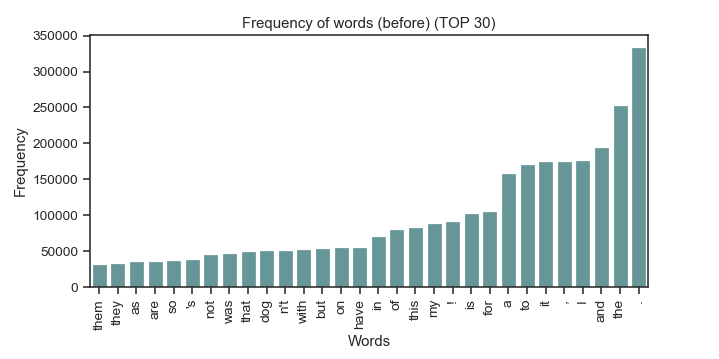

In [56]:
# Create a plot
plt.figure(figsize=(8,4))
sns.barplot(x=list(frequency_before_sorted.keys())[-30:], 
            y=list(frequency_before_sorted.values())[-30:], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (before) (TOP 30)')
plt.subplots_adjust(left=0.125, right=0.90, bottom=0.2, top=0.90)
plt.show()

There are many words that would not be useful to the model. I'm cleaning up the words.

In [57]:
# How many unique words?
before_word_number = len(set(token for review in tokens_list for token in review))
before_word_number

163302

In [58]:
# lower case
tokens_lower_list = [[token.lower() for token in review] for review in tokens_list]
tokens_lower_list[1][:5]

['my', 'chihuahua', 'loves', 'getting', 'one']

In [59]:
# How many kind of words were removed?
lower_word_number = len(set(token for review in tokens_lower_list for token in review))
before_word_number - lower_word_number

21944

### 2.8. Retaining only alphabets 

In [60]:
# Retain alphabetic words
tokens_alpha_list = [[token for token in review if token.isalpha()] for review in tokens_lower_list]
tokens_alpha_list[1][:10]

['my',
 'chihuahua',
 'loves',
 'getting',
 'one',
 'of',
 'these',
 'special',
 'treats',
 'every']

In [61]:
# How many kind of words were removed?
alph_word_number = len(set(token for review in tokens_alpha_list for token in review))
lower_word_number - alph_word_number

81249

### 2.9. Removing stop words

In [62]:
# Remove all stop words
cached_stop_words = stopwords.words('english')
tokens_nostop_list = [[token for token in review if token not in cached_stop_words] 
                      for review in tokens_alpha_list]
tokens_nostop_list[1][:10]

['chihuahua',
 'loves',
 'getting',
 'one',
 'special',
 'treats',
 'every',
 'night',
 'convenient',
 'use']

In [63]:
# How many kind of words were removed?
nostop_word_number = len(set(token for review in tokens_nostop_list for token in review))
alph_word_number - nostop_word_number

146

In [64]:
# Show the number of unique words
nostop_word_number

59963

### 2.10. Stemming and lemmatization

In [65]:
# Stemming by Snowball stemmer
snowball = SnowballStemmer(language='english')

tokens_stem_list = [[snowball.stem(token) for token in review] for review in tokens_nostop_list]
tokens_stem_list[0][:10]

['instal',
 'quick',
 'easi',
 'templat',
 'wrong',
 'adjust',
 'make',
 'work',
 'pound',
 'cat']

In [66]:
# How many kind of words were removed?
stem_word_number = len(set(token for review in tokens_stem_list for token in review))
nostop_word_number - stem_word_number

15070

In [67]:
# Lemmatization to tokens_stem_list
lem = nltk.WordNetLemmatizer()

tokens_lem_list = [[lem.lemmatize(token) for token in review] for review in tokens_stem_list]
tokens_lem_list[0][:10]

['instal',
 'quick',
 'easi',
 'templat',
 'wrong',
 'adjust',
 'make',
 'work',
 'pound',
 'cat']

In [68]:
# How many kind of words were removed?
stem_lem_word_number = len(set(token for review in tokens_lem_list for token in review))
stem_word_number - stem_lem_word_number

166

In [69]:
# Show the number of unique words
stem_lem_word_number

44727

### 2.11. Retaining only nouns

In [70]:
# Show POS
tag_list = [nltk.pos_tag(review) for review in tokens_stem_list]
tag_list[0][:5]

[('instal', 'JJ'),
 ('quick', 'JJ'),
 ('easi', 'NN'),
 ('templat', 'NN'),
 ('wrong', 'JJ')]

In [71]:
# Retain only nouns
token_noun_list = [[token[0] for token in review if token[1] == ('NN' or 'NNP' or 'NNPS' or 'VBG')] for review in tag_list]
token_noun_list[0][:10]

['easi',
 'templat',
 'work',
 'pound',
 'wont',
 'door',
 'pick',
 'litter',
 'box',
 'door']

In [72]:
# How many kind of words were removed?
noun_word_number = len(set(token for review in token_noun_list for token in review))
stem_word_number - noun_word_number

13105

In [73]:
# Show the number of unique words
noun_word_number

31788

### 2.12. Removing words appearing 4 times or less

Words appearing only a few are not useful to know the relationship with other products. I'm removing the words.

In [74]:
# Count the number of each word in the documents
# Put all words in a list
words_list_noun = [token for review in token_noun_list for token in review]

frequency_noun = nltk.FreqDist(words_list_noun)

In [75]:
# Collect words appearing 4 times or less
words_few = [k for k,v in frequency_noun.items() if v <= 4]

# How many words appearing 4 times or less?
print(len(words_few))

# Show the words
words_few[:10]

23870


['myselfi',
 'treatgood',
 'thanksdog',
 'healthygreat',
 'caremi',
 'shessinh',
 'judyr',
 'unsupport',
 'wallboard',
 'jur']

In [76]:
# Remove words appearing 4 times or less
token_more4_list = [[token for token in review if token not in words_few] for review in  token_noun_list]

In [77]:
# Show the number of unique words
len(set(token for review in token_more4_list for token in review))

7918

In [78]:
# Count the number of each word 
words_list_more4 = [token for review in token_more4_list for token in review]
frequency_more4 = nltk.FreqDist(words_list_more4)

# Sort the dictionary
frequency_more4_sorted = dict(sorted(frequency_more4.items(), key=lambda w: w[1]))

<IPython.core.display.Javascript object>


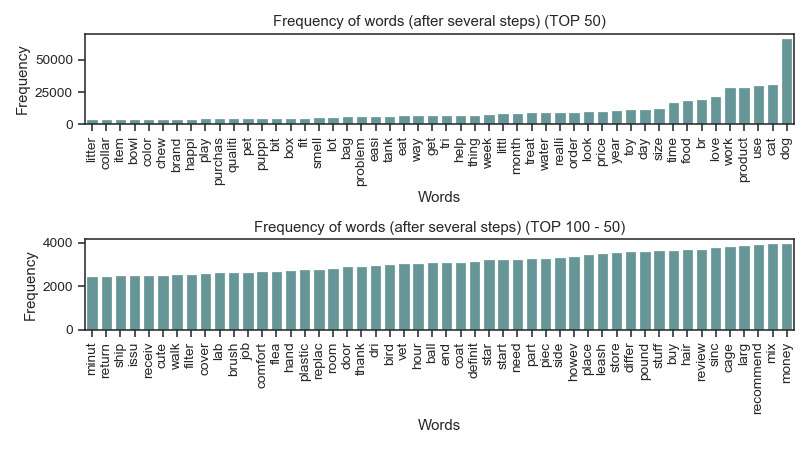

In [79]:
# Create a plot
plt.figure(figsize=(9,5))
plt.subplot(2,1,1)
sns.barplot(x=list(frequency_more4_sorted.keys())[-50:], y=list(frequency_more4_sorted.values())[-50:], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after several steps) (TOP 50)')

plt.subplot(2,1,2)
sns.barplot(x=list(frequency_more4_sorted.keys())[-100:-50], y=list(frequency_more4_sorted.values())[-100:-50], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after several steps) (TOP 100 - 50)')

plt.tight_layout()
plt.show()

Some words on this chart would not be usable.  I'm removing the words by hand.

In [80]:
# Collect words that would not be useful to categolize products from TOP 100 words
removed_words = ['br', 'product', 'work', 'love', 'time', 'day', 'year', 'price', 'realli', 'order', 'month', 'thing', 'littl',
                 'tri', 'week', 'way', 'get', 'help', 'problem', 'lot', 'easi', 'bit', 'review', 'purchas', 'happi', 
                 'recommend', 'differ', 'money', 'start', 'store', 'end', 'star', 'howev', 'buy', 'hour', 'need', 'definit', 
                 'replac', 'issu', 'chang', 'receiv', 'thank', 
                 'ship', 'return', 'minut', 'reason']

# Remove them from token_more4_list
token_removed_list = [[token for token in review if token not in removed_words] for review in  token_more4_list]

In [81]:
# Count the number of each word 
words_list_after = [token for review in token_removed_list for token in review]
frequency_after = nltk.FreqDist(words_list_after)

# Sort the dictionary
frequency_after_sorted = dict(sorted(frequency_after.items(), key=lambda w: w[1]))

<IPython.core.display.Javascript object>


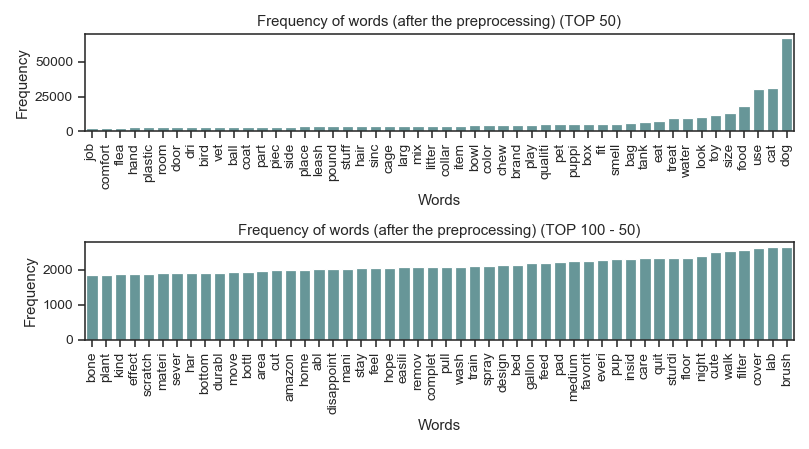

In [82]:
# Create a plot
plt.figure(figsize=(9,5))
plt.subplot(2,1,1)
sns.barplot(x=list(frequency_after_sorted.keys())[-50:], y=list(frequency_after_sorted.values())[-50:], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after the preprocessing) (TOP 50)')

plt.subplot(2,1,2)
sns.barplot(x=list(frequency_after_sorted.keys())[-100:-50], y=list(frequency_after_sorted.values())[-100:-50],
            color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after the preprocessing) (TOP 100 - 50)')

plt.tight_layout()
plt.show()

In [83]:
# Check the number of unique words
len(set(token for review in token_removed_list for token in review))

7872

In [84]:
# Confirm the number of products
len(token_removed_list)

19557

The number has not been changed.

In [85]:
# Check whether there is a product without any token
empty = [i for i in range(len(token_removed_list)) if token_removed_list[i] == []]
len(empty)

0

In [86]:
# Save token_moretokens_list as a csv file
# with open('token_list_10.csv', 'w', encoding='UTF-8') as f:
#     writer = csv.writer(f, lineterminator='\n')
#     writer.writerows(token_removed_list)

In [87]:
# Check the number of tokens per product
number_token_list = [len(tokens) for tokens in token_removed_list]

In [88]:
# Show the minimum  maximum
min(number_token_list), max(number_token_list)

(10, 235)

<IPython.core.display.Javascript object>


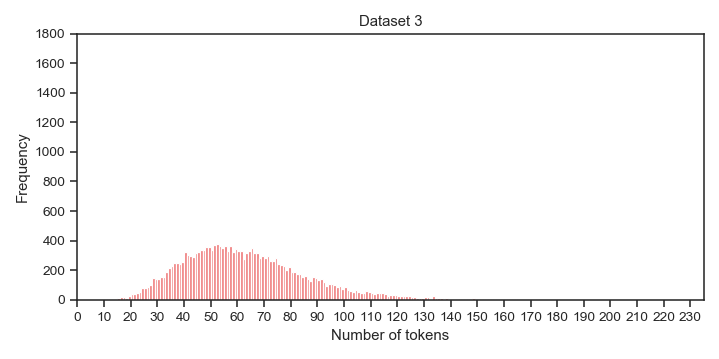

In [89]:
# Draw a strip plot and a count plot
plt.figure(figsize=(8,4))

plt.hist(number_token_list, bins=225, color='lightcoral')
plt.xlim([0,235])
plt.xticks(range(0,235,10))
plt.ylim([0,1800])
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.title('Dataset 3') 

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


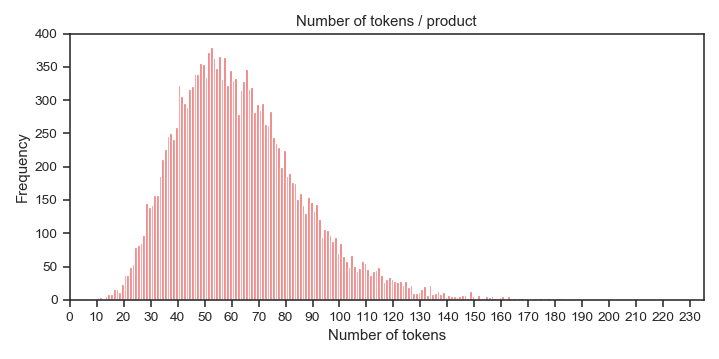

In [90]:
# Draw a strip plot and a count plot
plt.figure(figsize=(8,4))

plt.hist(number_token_list, bins=225, color='lightcoral')
plt.xlim([0,235])
plt.xticks(range(0,235,10))
plt.ylim([-0,400])
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.title('Number of tokens / product') 

plt.tight_layout()
plt.show()

In [91]:
# Calculate the 90 percentiles
np.percentile(number_token_list, [25, 50, 75, 90])

array([46., 60., 76., 94.])

In [92]:
# Calculate the mean
np.mean(number_token_list)

62.837705169504524

In [93]:
# Calculate the std
np.std(number_token_list)

24.09389058543421

90% of products have 10 to 137 tokens. The mean was 82.1.

## 3. Exploratory Data Analysis

3.1. The number of products relating to each animal kind  
3.2. The number of products relating to each application type  
3.3. The rough relationship between an animal kind and application type

### 3.1. The number of products relating to each animal kind

Count the rough numbers of products relating to a specific animal.

In [94]:
# Define a function returning the number of products having a specific word as a token
def count_word(word):
    count = 0
    for product in token_removed_list:
        if word in product:
            count += 1
    return count

In [95]:
# Count products having 'dog', 'puppi' or 'doggi' as a token
count_dog = count_word('dog')
count_puppi = count_word('puppi')
count_doggi = count_word('doggi')
count_dogs = count_dog + count_puppi + count_doggi
print('Dog:', count_dogs)

# Count products having 'cat', 'kitti', 'kitt' or 'kitten' as a token
count_cat = count_word('cat')
count_kitti = count_word('kitti')
count_kitt = count_word('kitt')
count_kitten = count_word('kitten')
count_cats = count_cat + count_kitti + count_kitt + count_kitten
print('Cat:', count_cats)

# Count products having 'bird' as a token
count_bird = count_word('bird')
count_chick = count_word('chick')
count_birds = count_bird + count_chick
print('Bird:', count_birds)

# Count products having 'fish' as a token
count_fish = count_word('fish')
print('Fish:', count_fish)

# Count products having 'rabit' as a token
count_rabbit = count_word('rabbit')
count_bunni = count_word('bunni')
count_rabbits = count_rabbit + count_bunni
print('Rabbit:', count_rabbits)

Dog: 16692
Cat: 6187
Bird: 997
Fish: 752
Rabbit: 806


<IPython.core.display.Javascript object>


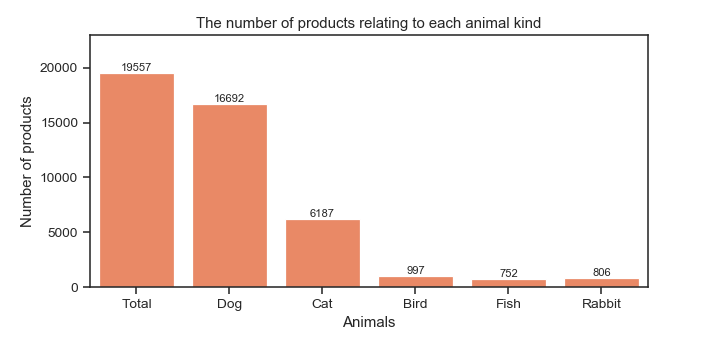

In [96]:
# Draw a bar plot
plt.figure(figsize=(8,4))

X = ['Total', 'Dog', 'Cat', 'Bird', 'Fish', 'Rabbit']
Y = [len(token_removed_list), count_dogs, count_cats, count_birds, count_fish, count_rabbits]

p = sns.barplot(x=X, y=Y, color='coral')
plt.xlabel('Animals')
plt.ylabel('Number of products')
plt.ylim([0, 23000])
plt.title('The number of products relating to each animal kind')

for x, y in zip([0, 1, 2, 3, 4, 5], Y):
    plt.text(x, y, y, ha='center', va='bottom', fontsize=9)

plt.subplots_adjust(left=0.125, right=0.90, bottom=0.2, top=0.90)
plt.show()

The main products were for dogs or cats. Especially, 87% of the products were related to dogs.

### 3.2. The number of products relating to each application type

Count the rough numbers of products relating to food, treats, toys, toilet, cages, clothes, or collars.

In [97]:
# Count products having 'food', 'dri' or 'wet' as a token
count_food = count_word('food')
count_dri = count_word('dri')
count_wet = count_word('wet')
count_foods = count_food + count_dri + count_wet
print('Food:', count_foods)

# Count products having 'treat', 'snack', or 'cooki' as a token
count_treat = count_word('treat')
count_snack = count_word('snack')
count_cooki = count_word('cooki')
count_treats = count_treat + count_snack + count_cooki
print('Treat:', count_treats)

# Count products having 'toy', 'tunnel', 'ball', 'rope', or 'stuff' as a token
count_toy = count_word('toy')
count_tunnel = count_word('tunnel')
count_ball = count_word('ball')
count_rope = count_word('rope')
count_stuff = count_word('stuff')
count_toys = count_toy + count_tunnel + count_ball + count_rope + count_stuff
print('Toy:', count_toys)

# Count products having 'litter', or 'pad' as a token
count_litter = count_word('litter')
count_pad = count_word('pad')
count_toilet = count_litter + count_pad
print('Toilet:', count_toilet)

# Count products having 'cage', 'crate', 'carrier', or 'kennel' as a token
count_cage = count_word('cage')
count_crate = count_word('crate')
count_carrier = count_word('carrier')
count_kennel = count_word('kennel')
count_cages = count_cage + count_crate + count_carrier + count_kennel
print('Cage:', count_cages)

# Count products having 'shirt', 'coat', 'sweater', or 'costum' as a token
count_shirt = count_word('shirt')
count_coat = count_word('coat')
count_sweater = count_word('sweater')
count_costum = count_word('costum')
count_clothes = count_shirt + count_coat + count_sweater + count_costum
print('Clothes:', count_clothes)

# Count products having 'collar', or 'leash' as a token
count_collar = count_word('collar')
count_leash = count_word('leash')
count_collar_leash = count_collar + count_leash
print('Collar&Leash:', count_collar_leash)

Food: 6802
Treat: 3552
Toy: 6980
Toilet: 1862
Cage: 2115
Clothes: 2131
Collar&Leash: 2438


<IPython.core.display.Javascript object>


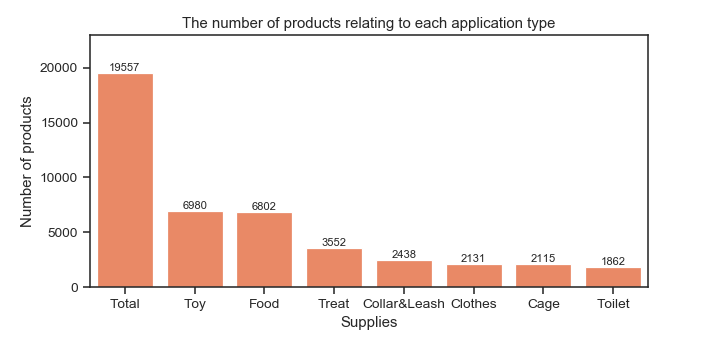

In [98]:
# Draw a bar plot
plt.figure(figsize=(8,4))

X2 = ['Total', 'Toy', 'Food', 'Treat', 'Collar&Leash', 'Clothes', 'Cage', 'Toilet']
Y2 = [len(token_removed_list), count_toys, count_foods, count_treats, count_collar_leash, count_clothes,count_cages, count_toilet]

sns.barplot(x=X2, y=Y2, color='coral')
plt.xlabel('Supplies')
plt.ylabel('Number of products')
plt.ylim([0, 23000])
plt.title('The number of products relating to each application type')

for x, y in zip([0, 1, 2, 3, 4, 5, 6, 7], Y2):
    plt.text(x, y, y, ha='center', va='bottom', fontsize=9)

plt.subplots_adjust(left=0.125, right=0.90, bottom=0.2, top=0.90)
plt.show()

The top 2 categories are Food and Toy, but he products are relatively spread.

### 3.3. The rough relationship between an animal kind and application type

I pick up Dog and Cat as animal kind categories, and Toy and Food as application type categories. Check the relationships between them.

In [99]:
# Define a function making coordinates. word1 and word2 can accept a list.
def make_coordinate(list_name, word1, word2, num):
    for i in range(len(token_removed_list)):
        product = token_removed_list[i]
        for token in product:
            if token in word1:
                list_name[i][num] += 1
                break
        for token in product:
            if token in word2:
                list_name[i][num] += 2
                break
    return list_name

In [100]:
# Make coorfinates showing the presence of words; dog and/or cat,and toy and/or food
# [1, 0] means the product has 'dog' and doesn't have 'cat', 'toy', or 'food' as the tokens
# [3, 2] means the product has 'dog', 'cat', and 'food' as the tokens

# Make an initial list
animal_supply = [[0, 0] for i in range(len(token_removed_list))]

# Make coorfinates
animal_supply = make_coordinate(animal_supply, ['dog','puppi','doggi'], ['cat','kitti','kitt','kitten'] , 0)
animal_supply = make_coordinate(animal_supply, ['toy','tunnel','ball','rope','stuff'], ['food','dri','wet'], 1)
animal_supply[:10]

[[2, 0],
 [1, 0],
 [1, 2],
 [1, 0],
 [1, 1],
 [3, 2],
 [0, 1],
 [0, 0],
 [1, 0],
 [1, 2]]

<IPython.core.display.Javascript object>


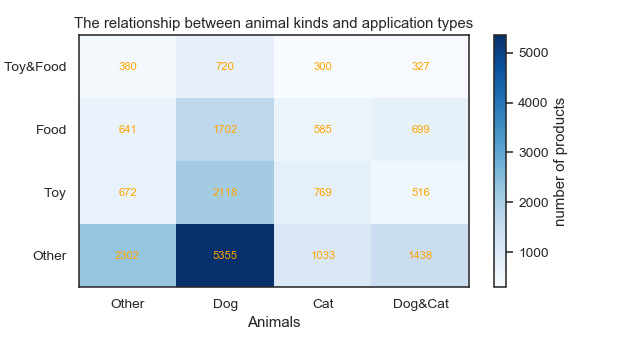

In [101]:
# Make an initial list to draw a pseudocolor plot
mesh_list = [[0,0,0,0], [0,0,0,0],[0,0,0,0],[0,0,0,0]]

# Count the number of products fitting each compartment and make the numpy array
for product in animal_supply:
    mesh_list[product[1]][product[0]] += 1
mesh_arr = np.array(mesh_list)

# Make mesh
u = np.linspace(-1, 1, 5)
v = np.linspace(-1, 1, 5)
X,Y = np.meshgrid(u, v)

# Draw a pseudocolor plot
plt.figure(figsize=(7,4))
plt.pcolor(mesh_arr, cmap='Blues')
pp = plt.colorbar()
pp.set_label('number of products')
plt.xticks(ticks=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], labels=['','Other', '', 'Dog', '', 'Cat', '', 'Dog&Cat', ''])
plt.yticks(ticks=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], labels=['','Other', '', 'Toy', '', 'Food', '', 'Toy&Food', ''])
plt.tick_params(bottom=False, left=False)
plt.xlabel('Animals')
plt.ylabel('Supplies')
plt.title('The relationship between animal kinds and application types')

for y in [0.5, 1.5, 2.5, 3.5]:
    for x in [0.5, 1.5, 2.5, 3.5]: 
        plt.text(x, y, mesh_list[int(y-0.5)][int(x-0.5)], ha='center', va='center', fontsize=9, color='orange')

plt.subplots_adjust(left=0.125, right=0.90, bottom=0.2, top=0.90)
plt.show()

Food and toys for dogs are the largest two categories on the chart, but many products are in Other. I will categorize them more precisely in the modeling part of this project. 

The modeling part is showed in a different jupyter notebook. See a jupyter notebook for modeling. 